# **Experimenting with 101 food classes of Food Vision with 10% of the data**

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
import tensorflow.keras.layers as layers
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
from helper_functions import *
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
unzip_data("101_food_classes_10_percent.zip")
train_dat_10 = "/content/101_food_classes_10_percent/train"
test_dat_10 = "/content/101_food_classes_10_percent/test"

--2021-11-08 20:49:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 108.177.121.128, 142.250.103.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   160MB/s    in 11s     

2021-11-08 20:50:07 (137 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

--2021-11-08 20:50:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP r

PreProcessing data 

In [2]:
train_data_10 = tf.keras.preprocessing.image_dataset_from_directory(train_dat_10,label_mode="categorical",image_size=IMG_SIZE)
test_data_10 = tf.keras.preprocessing.image_dataset_from_directory(test_dat_10,label_mode="categorical",image_size=IMG_SIZE, shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [3]:
cp_path = "101_ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(cp_path,
                                                 save_best_only = True, 
                                                 save_weights_only = True,
                                                 monitor = "val_accuracy")

In [4]:
aug_layer = tf.keras.Sequential([
                                 preprocessing.RandomFlip("horizontal"),
                                 preprocessing.RandomHeight(0.2),
                                 preprocessing.RandomWidth(0.2),
                                 preprocessing.RandomZoom(0.2),
                                 preprocessing.RandomZoom(0.2)
], name = "data-aug-layer")

**Building a model which has both an augmentation layer and last 5 layers of EfficientNet unfrozen**

In [5]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True

input_shape = (224,224,3)

inputs = layers.Input(shape=input_shape)

z = aug_layer(inputs)
z = base_model(z,training = False)
z = layers.GlobalAveragePooling2D()(z)

for layer in base_model.layers[:-5]:
  layer.trainable = False
outs = layers.Dense(int(len(train_data_10.class_names)), activation="softmax")(z)
model_1 = tf.keras.Model(inputs,outs)

#for layer in base_model.layers[:-10]:
#  layer.trainable = False

model_1.compile(loss="categorical_crossentropy",metrics=["accuracy"],optimizer= optimizers.Adam(learning_rate=0.0001))
model_1.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
data-aug-layer (Sequential)  (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 4,178,952
Trainable params: 910,821
Non-trainable params: 3,268,131
_________________________________________________________________


In [6]:
track2 = model_1.fit(train_data_10,
                     epochs = 5,
                     steps_per_epoch= len(train_data_10),
                     validation_data=test_data_10,
                     validation_steps=int(0.15 * len(test_data_10)),
                     callbacks =[create_tensorboard_callback("training","onthe10%"),cp_callback])

Saving TensorBoard log files to: training/onthe10%/20211108-205056
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


237/237 [==============================] - 163s 527ms/step - loss: 4.1295 - accuracy: 0.1199 - val_loss: 3.5008 - val_accuracy: 0.2092
Epoch 2/5
237/237 [==============================] - 92s 385ms/step - loss: 2.7243 - accuracy: 0.3582 - val_loss: 2.6003 - val_accuracy: 0.3649
Epoch 3/5
237/237 [==============================] - 86s 360ms/step - loss: 2.1832 - accuracy: 0.4610 - val_loss: 2.3541 - val_accuracy: 0.4137
Epoch 4/5
237/237 [==============================] - 82s 345ms/step - loss: 1.9335 - accuracy: 0.5197 - val_loss: 2.2748 - val_accuracy: 0.4190
Epoch 5/5
237/237 [==============================] - 82s 342ms/step - loss: 1.7640 - accuracy: 0.5523 - val_loss: 2.1784 - val_accuracy: 0.4399


Plotting loss curves

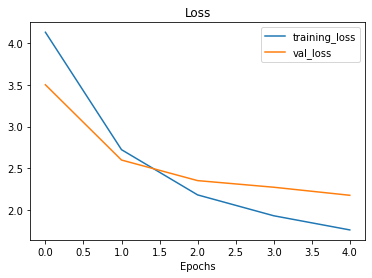

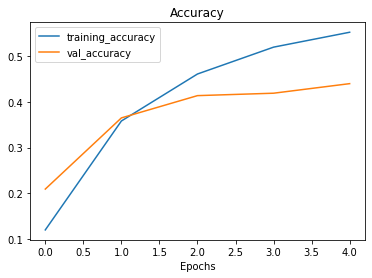

In [7]:
plot_loss_curves(track2)

**Further Training to see if the model improves**

In [9]:
epoks = 10
track2_finetuned = model_1.fit(train_data_10,
                     epochs = epoks,
                     steps_per_epoch= len(train_data_10),
                     validation_data=test_data_10,
                     validation_steps=int(0.15 * len(test_data_10)),
                     callbacks =[create_tensorboard_callback("training","finetuned"),cp_callback],
                     initial_epoch = track2.epoch[-1])

Saving TensorBoard log files to: training/finetuned/20211108-210154
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


237/237 [==============================] - 75s 314ms/step - loss: 1.6368 - accuracy: 0.5797 - val_loss: 2.0833 - val_accuracy: 0.4658
Epoch 6/10
237/237 [==============================] - 71s 299ms/step - loss: 1.5428 - accuracy: 0.6004 - val_loss: 2.1171 - val_accuracy: 0.4568
Epoch 7/10
237/237 [==============================] - 69s 287ms/step - loss: 1.4420 - accuracy: 0.6334 - val_loss: 2.1431 - val_accuracy: 0.4494
Epoch 8/10
237/237 [==============================] - 72s 303ms/step - loss: 1.3659 - accuracy: 0.6462 - val_loss: 2.0201 - val_accuracy: 0.4775
Epoch 9/10
237/237 [==============================] - 73s 304ms/step - loss: 1.3042 - accuracy: 0.6635 - val_loss: 2.0313 - val_accuracy: 0.4756
Epoch 10/10
237/237 [==============================] - 63s 266ms/step - loss: 1.2379 - accuracy: 0.6792 - val_loss: 2.0392 - val_accuracy: 0.4719


Plotting Loss curves

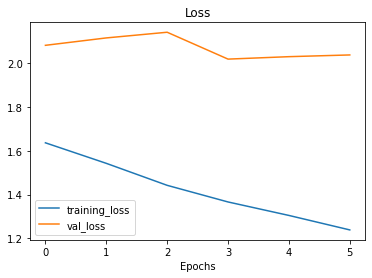

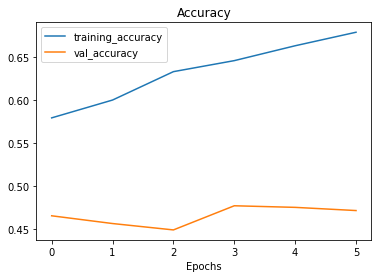

In [10]:
plot_loss_curves(track2_finetuned)